<a href="https://colab.research.google.com/github/sanyam83/learnopencv/blob/master/ALPR/OCR_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

## Installing dependencies

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

In [ ]:
%cd PaddleOCR
!pip install -r requirements.txt

In [ ]:
!python -m pip install paddlepaddle-gpu==2.0.0 -i https://mirror.baidu.com/pypi/simple


In [ ]:
!pip install python-Levenshtein

In [ ]:
# Impoeting required libraries.
import cv2
import os
import numpy as np
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

## Dataset preprocessing

In [ ]:
# Creating a function for displaying images along with annotations.
def disp(pth, gt_annot = '', gt = False, out = False, num = 10):
  img_arr = []
  annot_arr = []
  
  # Looping through files in the directory.
  for fimg in sorted((os.listdir(pth))):
    if fimg.endswith('.jpg') or fimg.endswith('.png'):
      demo = img.imread(pth+fimg)

      # Appending image arrays and annotations to different lists.
      img_arr.append(demo)
      if out:
        with open(pth + ''.join(fimg.split())[:-8]+ '.txt') as f:
          out = f.read()
          f.close()
        annot_arr.append(out)
        
      if gt:
        with open(gt_annot) as f:
          for line in f:
            if line.split('.')[0] == fimg.split('.')[0]: 
              gt = line.split('"')[1].lower()
              annot_arr.append(gt)
              break

      if len(img_arr) == num:
          break

  # Plotting the images.
  _, axs = plt.subplots(2, 5, figsize=(25, 14))
  axs = axs.flatten()
  for cent, ax,val  in zip(img_arr, axs, annot_arr):
      ax.imshow(cent)
      ax.set_title(val,fontsize=25)
  plt.show()

Get IC15 dataset from [here](https://drive.google.com/drive/folders/1u7kmEON_a4uozQNRRoneBdvptOzDc4g_?usp=sharing) and store in a new folder say ocr_comparsion

### Ground Truth dataset

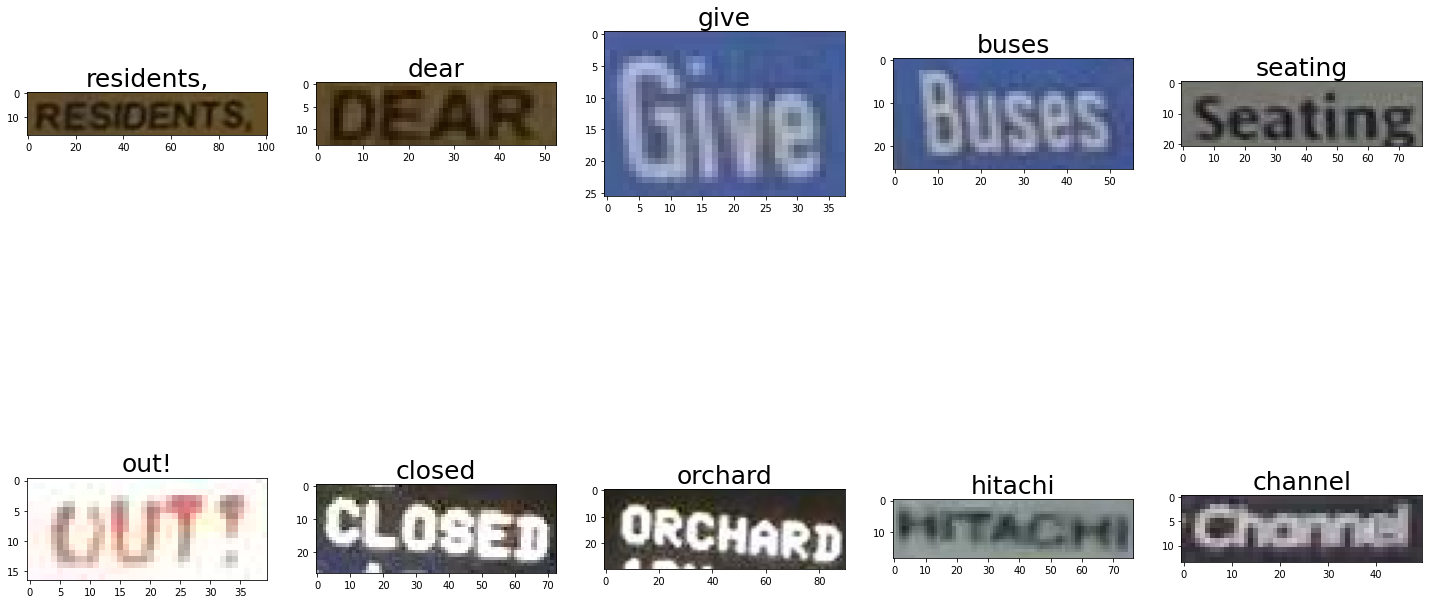

In [ ]:
pth = '../ocr_comparsion/IC15_test/'
annot = '../ocr_comparsion//gt-test.txt'
disp(pth, annot, gt = True, num = 10)

## Inferencing

In [ ]:
import time
import numpy

In [ ]:
from tools.infer.predict_rec import *
import tools.infer.utility as utility
from ppocr.postprocess import build_post_process
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read_gif

### Utility functions

In the following code warmup is done before the actual inferencing. The warmup us done to warm the GPU up when running for the first time as for the first time GPU takes alot of time to run because of the need to intitalize the memory and etc and it helps it to reach its maximum power. Hence the speed is faster for inferencing after the warmup

Inference time will be shown at the end 

In [ ]:
def rec(args, out_path, input, rec_model_dir,rec_image_shape = "3, 32, 320", rec_char_type = "ch", rec_algorithm = "CRNN", show = True, save = True):
    args.rec_model_dir = rec_model_dir
    args.rec_image_shape = rec_image_shape
    args.rec_char_type = rec_char_type
    args.rec_algorithm = rec_algorithm
    t1 = 0
    t2 = 0
    tot = []
    
    image_file_list = get_image_file_list(input)
    text_recognizer = TextRecognizer(args)
    valid_image_file_list = []
    img_list = []

    # warmup 10 times
    if args.warmup:
        image = np.random.uniform(0, 255, [32, 320, 3]).astype(np.uint8)
        for i in range(10):
            res = text_recognizer([image])

    for image_file in image_file_list:
        image, flag = check_and_read_gif(image_file)
        if not flag:
            image = cv2.imread(image_file)
        if image is None:
            logger.info("error in loading image:{}".format(image_file))
            continue
        valid_image_file_list.append(image_file)
        img_list.append(image)
    t1 = time.time()
    try:
        rec_res, _ = text_recognizer(img_list)
    except Exception as E:
        logger.info(traceback.format_exc())
        logger.info(E)
        exit()
    t2 = time.time()
    fps = str(t2-t1)
    for ino in range(len(img_list)):
        logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                              rec_res[ino]))
    logger.info("Time taken recognize all images : {}".format(fps))
    print(len(image_file_list))
    logger.info("Average fps : {}".format(1/(float(fps)/len(image_file_list))))
    if args.benchmark:
        text_recognizer.autolog.report()
    #cv2.putText(image, str(rec_res[ino]),(0, int(15 * 1)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=1)
    if show:
      plt.figure(figsize = (25,14))
      plt.imshow(image)
      plt.show()
    if save:
      cv2.imwrite(os.path.join(out_path,input.split('/')[-1].split('.')[0] + '_rec' + '.jpg'),image)
    with open(os.path.join(out_path,input.split('/')[-1].split('.')[0] + '.txt'), 'w') as f:
      f.write(str(rec_res[ino]))

calculating levenshtein distance i.e. changes required to acheive the desired text

The less the score the better

In [ ]:
def score_calc(pth, annot):
  from Levenshtein import distance
  score_all = []
  
  # Looping through the files.
  for out_file in os.listdir(pth):
    if out_file.endswith('.txt'):
      with open(os.path.join(pth, out_file), 'rb') as f:
        out = f.read()
        f.close()
      # Filtering OCR output to get the required text.
      try:
        out = str(out).split('(')[1].split(',')[0].replace("'", '').lower()
      except:
        continue

      # Calculating the score between ground truth and predicted text.
      with open(annot) as f:
        for line in f:
          #print(out_file.split('.')[0], line.split(',')[0])
          if line.split('.')[0] == out_file.split('.')[0]: 
            gt = line.split('"')[1].lower()
            score = distance(str(out), str(gt))
            score_all.append(score)
            break
  print("final score:", sum(score_all)/len(score_all))

### PaddlePaddle-OCR (Lightweight)

In [ ]:
# Downloading model
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.1/chinese/ch_PP-OCRv2_rec_infer.tar
!tar xf ch_PP-OCRv2_rec_infer.tar

In [ ]:
out_path = '../output/lightweight_paddle_output'
rec_model_dir = './ch_PP-OCRv2_rec_infer'
input = '../ocr_comparison/IC15_test'
sys.argv = ['']
rec(utility.parse_args(), out_path, input, rec_model_dir, show = False)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65281 missing from current font.
  font.set_text(s, 0, flags=flags)


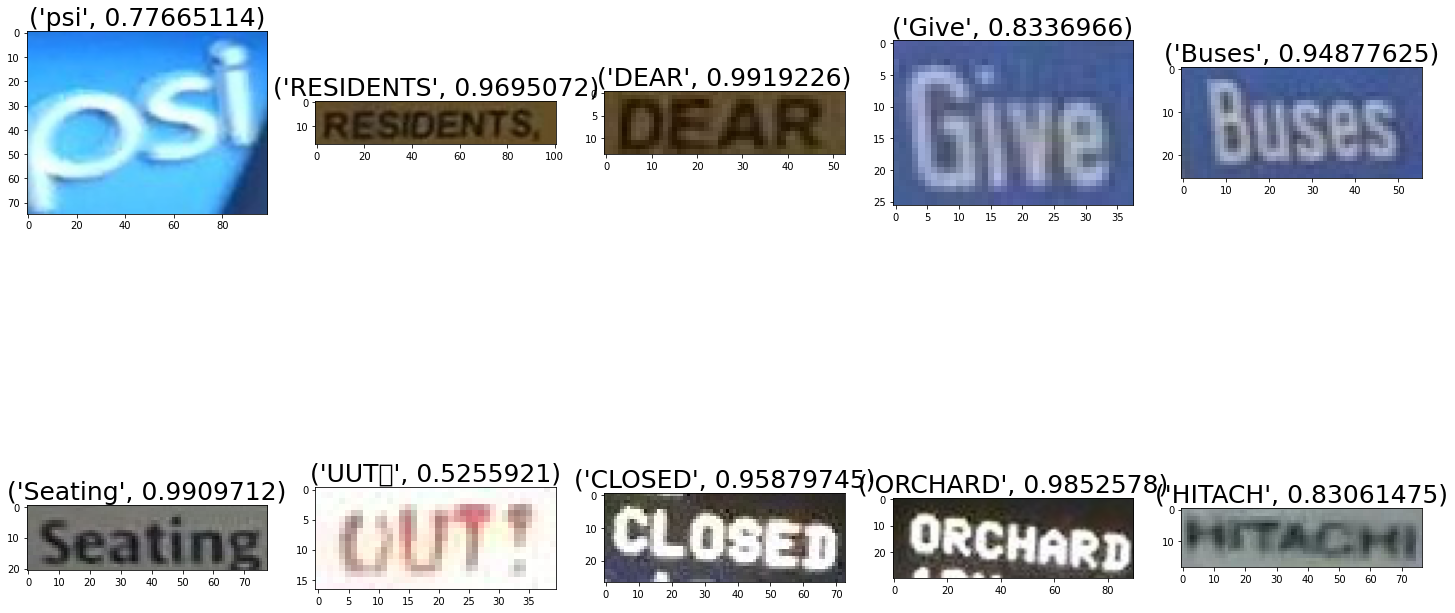

In [ ]:
pth = '../output/lightweight_paddle_output/'
disp(pth, out = True, num = 10)

In [ ]:
result_path = '../output/lightweight_paddle_output'
gt = '../ocr_comparison/gt-test.txt'
score_calc(result_path, gt)

cont
final score: 3.162


### CRNN

In [ ]:
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_server_v2.0_rec_infer.tar
!tar xf ch_ppocr_server_v2.0_rec_infer.tar

In [ ]:
out_path = '../output/CRNN_output'
image_dir = '../ocr_comparison/IC15_test'
rec_model_dir = './ch_ppocr_server_v2.0_rec_infer'
sys.argv = ['']
rec(utility.parse_args(), out_path, image_dir, rec_model_dir, show = False)

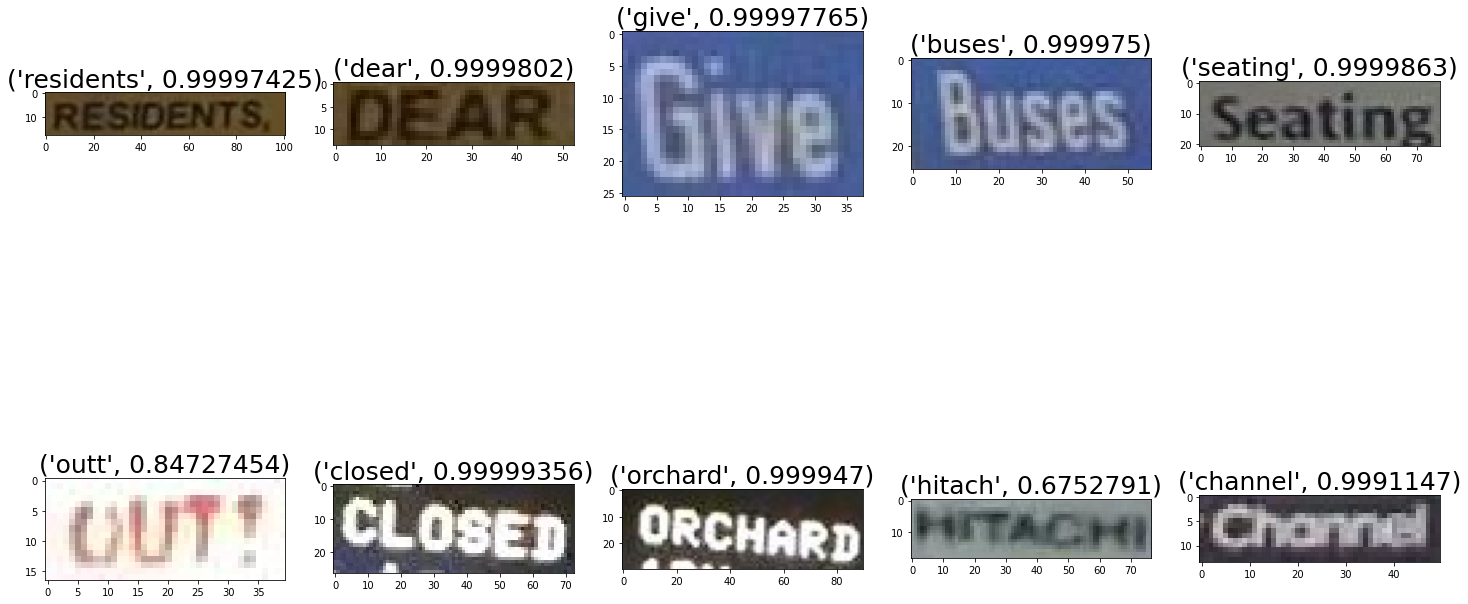

In [ ]:
pth = '../output/CRNN_output/'
disp(pth, out = True, num = 10)

In [ ]:
result_path = '../output/CRNN_output'
gt = '../ocr_comparison/gt-test.txt'
score_calc(result_path, gt)

final score: 20.687221


### SRN

In [ ]:
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/rec_r50_vd_srn_train.tar
%cd ./inference
!tar xf rec_r50_vd_srn_train.tar

In [ ]:
%cd ../
out_path = '../output/SRN_output'
image_dir = '../ocr_comparison/IC15_test'
rec_model_dir = './inference/srn'
sys.argv = ['']
rec(utility.parse_args(), out_path, image_dir, rec_model_dir, rec_image_shape = '1,64,256', rec_char_type = 'en',rec_algorithm = 'SRN', show = False)

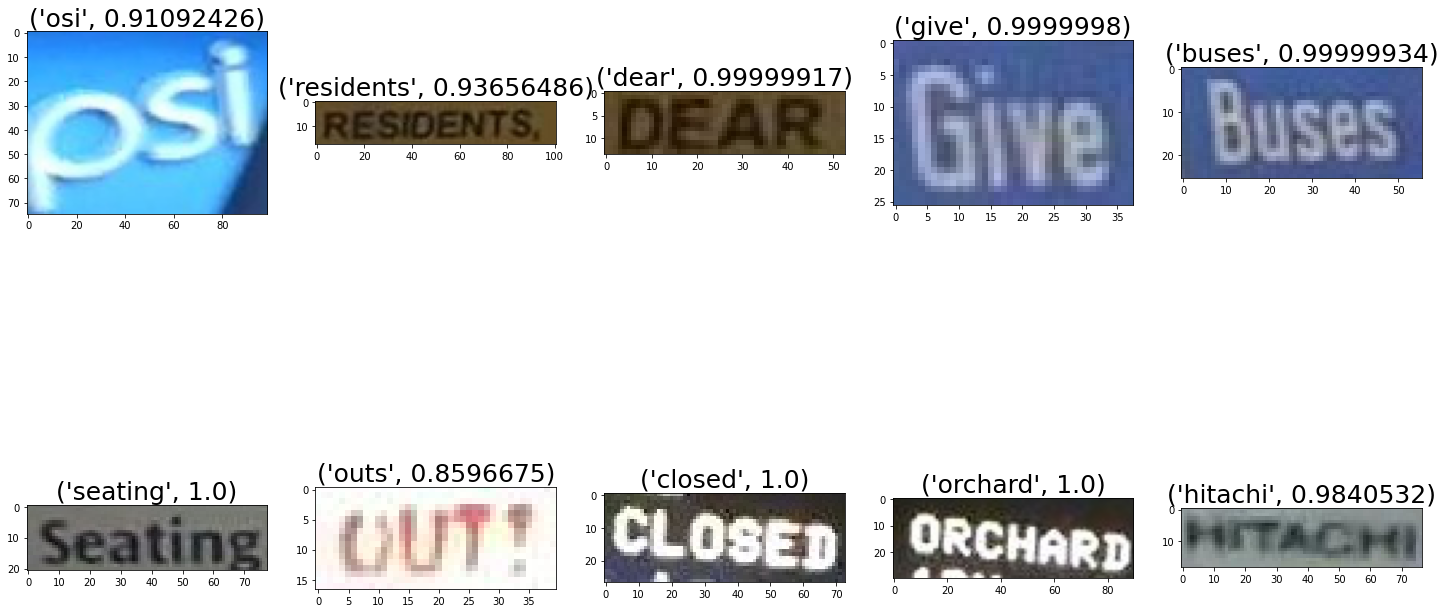

In [ ]:
pth = '../output/SRN_output/'
disp(pth, out = True, num = 10)

In [ ]:
result_path = '../output/SRN_output'
gt = '../ocr_comparison/gt-test.txt'
score_calc(result_path, gt)

final score: 0.774
